In [59]:
import numpy as np
import pandas as pd
import math
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

def printVar (varname, var):

    print(varname)
    print(var)

def saveArray (name, array):

    pd.DataFrame(array).to_csv("savedVariables/" + name + ".csv", index=False, header=None)



In [60]:
# Solve the 2D Navier-Cauchy equation using a segregated finite volume method

# Define mesh geometry and boundary conditions

Lx = .01 #width of domain
Ly = .01 #height of domain

fac = 1

tr_left_x = -1e-6*fac      #u boundary condition at the left boundary
tr_left_y =  1e-6*0     #v boundary condition at the left boundary

tr_right_x = +1e-6*fac    #u boundary condition at the right boundary
tr_right_y = 1e-6*0     #v boundary condition at the right boundary

tr_top_x = 1e-6*0       #u boundary condition at the top boundary
tr_top_y = +1e-6*fac       #v boundary condition at the top boundary

tr_bottom_x = -1e-6*0    #u boundary condition at the bottom boundary 
tr_bottom_y = -1e-6*fac    #v boundary condition at the bottom boundary

nx = 8          #number of control volumes in the x-direction
ny = 8            #number of control volumes in the y-direction


In [61]:
sys.path.append("../../Classes/")

from index_and_direction import dim

# dim().nx = 9
# dim().ny = 9

# print(dim().nx)

In [62]:
print(dim().nx)

8


In [63]:
from index_and_direction import index
from index_and_direction import boundary_point_index
from index_and_direction import cell_index
from index_and_direction import displacement

In [64]:
# Define material properties

rho = 8050         #density of steel in kg/m^3
mu = 78*10e9       #shear modulus in Pa
K = 1.6*10e11      #bulk modulus in Pa

Lambda = K - (2/3)*mu

#print(Lambda)

In [65]:
## Define required variables

tf = 0.01           #total time in seconds
dx = Lx/nx          #length of each control volume in the x-direction
dy = Ly/ny          #length of each control volume in the y-direction
dt = tf/10          #size of time steps
Sfx = dy            #area vector x component (Area of East and West Faces)
Sfy = dx            #area vector y component (Area of North and South Faces)


In [66]:
## Define  position and time vectors

t = np.array(np.arange(0,tf, dt))        #time vector (could possibly use a list)
x = np.zeros((1,nx+2))   #position vector defining the center points of the control volumes in the x-direction.
x[0,nx+1] = Lx
x[0,1:nx+1] = np.arange(dx/2,Lx,dx)

t = np.array(np.arange(0,tf, dt))        #time vector (could possibly use a list)
y = np.zeros((1,ny+2))   #position vector defining the center points of the control volumes in the y-direction.
y[0,ny+1] = Ly
y[0,1:ny+1] = np.arange(dy/2,Ly,dy)

In [67]:
## Define required displacement matrices and b vector

u_new = np.zeros([(ny+2)*(nx+2),2])         #unknown displacements at t + 1    (Column 1 = x, Column2 = y)
u_old = np.zeros([(ny+2)*(nx+2),2])         #displacement at time t
u_old_old = np.zeros([(ny+2)*(nx+2),2])     #displacement at time t - 1

#rhs vector
b_x = np.zeros([(ny+2)*(nx+2),1])
b_y = np.zeros([(ny+2)*(nx+2),1])

## X equation:

In [68]:
class A(index, displacement):

    val = "value that stays in class without changning with instance"

    def __init__(self, xy):

        if xy == "x":

            self.a_P = (rho*dx*dy/(dt**2))+((4*mu+2*Lambda)*Sfx)/dx + ((2*mu)*Sfy)/dy
            self.a_N = + A.coef(xy, "N", "u")*(Sfy)/dy
            self.a_S = - A.coef(xy, "S", "u")*(Sfy)/dy
            self.a_E = + A.coef(xy, "E", "u")*(Sfx)/dx
            self.a_W = - A.coef(xy, "W", "u")*(Sfx)/dx

        if xy == "y":

            self.a_P = (rho*dx*dy/(dt**2))+((4*mu+2*Lambda)*Sfy)/dy + ((2*mu)*Sfx)/dx 
            self.a_N = + A.coef(xy, "N", "v")*(Sfy)/dy
            self.a_S = - A.coef(xy, "S", "v")*(Sfy)/dy
            self.a_E = + A.coef(xy, "E", "v")*(Sfx)/dx
            self.a_W = - A.coef(xy, "W", "v")*(Sfx)/dx

    def createMatrix(self):

        A_no_boundary = np.zeros([(ny+2)*(nx+2), (ny+2)*(nx+2)])
        # A_no_boundary = csr_matrix(A_no_boundary)  

        for j in np.arange(2, ny):     

            for k in np.arange((j*(nx+2)+2), (j*(nx+2)+nx)):  
                
                A_no_boundary[k,k] = self.a_P
                A_no_boundary[k,index(k).n] = -self.a_N
                A_no_boundary[k,k-nx-2] = -self.a_S
                A_no_boundary[k, index(k).e] = -self.a_E
                A_no_boundary[k, index(k).w] = -self.a_W

        return A_no_boundary

    # b temporal term
    def b_temp(u_old, u_old_old, k, xy):

        if xy == "x":
            b_temporal_term = (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy)
        if xy == "y":
            b_temporal_term = (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy)
        
        return b_temporal_term
    
    def b_diff(k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"

        b_diffusion = (
                                Sfy*A.coef(xy, "N", uv)*(
                                    (A.corner("NE", uv, u_previous, k) - A.corner("NW", uv, u_previous, k))
                                    /dx)
                                + 
                                Sfy*A.coef(xy, "S", uv)*(
                                    (A.corner("SE", uv, u_previous, k) - A.corner("SW", uv, u_previous, k))
                                    /dx)
                                +
                                Sfx*A.coef(xy, "E", uv)*(
                                    (A.corner("NE", uv, u_previous, k) - A.corner("SE", uv, u_previous, k))
                                    /dy)
                                +
                                Sfx*A.coef(xy, "W", uv)*(
                                    (A.corner("NW", uv, u_previous, k) - A.corner("SW", uv, u_previous, k))
                                    /dy)
        )

        return b_diffusion
    
    def corner(corner_placement, uv, u_previous, k):
        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        if corner_placement == "NE":
            return (1/4)*(disp.P + disp.NE + disp.N + disp.E)
        if corner_placement == "SE":
            return (1/4)*(disp.P + disp.SE + disp.S + disp.E)
        if corner_placement == "SW":
            return (1/4)*(disp.P + disp.SW + disp.S + disp.W)
        if corner_placement == "NW":
            return (1/4)*(disp.P + disp.NW + disp.N + disp.W)


    
    def coef(xy, face, uv):
        # could have and statements
        if xy == "x":
            if face == "N":
                if uv == "u":
                    return mu
                if uv == "v":
                    return mu
            if face == "S":
                if uv == "u":
                    return - mu
                if uv == "v":
                    return - mu
            if face == "E":
                if uv == "u":
                    return 2*mu + Lambda
                if uv == "v":
                    return Lambda
            if face == "W":
                if uv == "u":
                    return - (2*mu + Lambda)
                if uv == "v":
                    return - Lambda

        elif xy == "y":
            if face == "N":
                if uv == "u":
                    return Lambda
                if uv == "v":
                    return 2*mu + Lambda
            if face == "S":
                if uv == "u":
                    return - Lambda
                if uv == "v":
                    return - (2*mu + Lambda)
            if face == "E":
                if uv == "u":
                    return mu
                if uv == "v":
                    return mu
            if face == "W":
                if uv == "u":
                    return - mu
                if uv == "v":
                    return - mu

u_previous = u_new

A.b_diff(25, "x", u_previous)

0.0

In [69]:
class boundaryCellTraction(A):

    def __init__(self, edges, xy):
        
        sw_S, sw_N, sw_W, sw_E = 1, 1, 1, 1

        for edge in edges:
            if edge == "b": sw_S = 0
            if edge == "t": sw_N = 0
            if edge == "l": sw_W = 0
            if edge == "r": sw_E = 0
        
        self.a_P = (rho*dx*dy/(dt**2)) + A(xy).a_N*sw_N + A(xy).a_S**sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W
        
        self.a_N = A(xy).a_N 
        self.a_S = A(xy).a_S 
        self.a_E = A(xy).a_E 
        self.a_W = A(xy).a_W 

        # self.a_faces = A(xy).a_N*sw_N + A(xy).a_S*sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W 

    def b_temp(u_old, u_old_old, k, xy):      
        return A.b_temp(u_old, u_old_old, k, xy)
    
    def b_diff(edges, k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"
            
        N_term =(
                    Sfy*A.coef(xy, "N", uv)*(
                    (boundaryCellTraction.corner(edges, "NE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "NW", uv, u_previous, k))
                    /dx)
                )
        S_term =(
                    Sfy*A.coef(xy, "S", uv)*(
                        (boundaryCellTraction.corner(edges, "SE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SW", uv, u_previous, k))
                        /dx)
                ) 
        E_term =(
                    Sfx*A.coef(xy, "E", uv)*(
                        (boundaryCellTraction.corner(edges, "NE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SE", uv, u_previous, k))
                        /dy)
                ) 
        W_term =(
                    Sfx*A.coef(xy, "W", uv)*(
                        (boundaryCellTraction.corner(edges, "NW", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SW", uv, u_previous, k))
                        /dy)
                )

        for edge in edges:

            if (edge == "b") & (xy == "x") : S_term =  Sfy*tr_bottom_x  
            if (edge == "b") & (xy == "y") : S_term =  Sfy*tr_bottom_y  
            if (edge == "t") & (xy == "x") : N_term =  Sfy*tr_top_x  
            if (edge == "t") & (xy == "y") : N_term =  Sfy*tr_top_y  
            if (edge == "l") & (xy == "x") : W_term =  Sfy*tr_left_x  
            if (edge == "l") & (xy == "y") : W_term =  Sfy*tr_left_y  
            if (edge == "r") & (xy == "x") : E_term =  Sfy*tr_right_x  
            if (edge == "r") & (xy == "y") : E_term =  Sfy*tr_right_y        

        b_diffusion = (N_term + S_term + E_term + W_term)

        return b_diffusion
    
    def corner(edges, corner_placement, uv, u_previous, k):

        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        if corner_placement == "NE":
            corner =  (1/4)*(disp.P + disp.NE + disp.N + disp.E)
        if corner_placement == "SE":
            corner =  (1/4)*(disp.P + disp.SE + disp.S + disp.E)
        if corner_placement == "SW":
            corner =  (1/4)*(disp.P + disp.SW + disp.S + disp.W)
        if corner_placement == "NW":
            corner =  (1/4)*(disp.P + disp.NW + disp.N + disp.W)

        for edge in edges:
            if (edge == "b") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.S)
            if (edge == "b") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.S)

            if (edge == "t") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.N)
            if (edge == "t") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.N)

            if (edge == "l") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.W)
            if (edge == "l") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.W)

            if (edge == "r") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.E)
            if (edge == "r") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.E)
        
        return corner

# boundaryCellTraction.b_diff(["b", "l"], 14, "x", u_previous)
   

In [70]:
## Time loop

!rm -r savedVariables
! mkdir savedVariables

for time in t:

    print("\nTime = " + str(time))
    
    # Set number of maximum iterations for convergence
    
    icorr = 1
    maxcorr = 100000

    # Make directory

    ! mkdir savedVariables/{time}
    
    while True:
    # for iteration in [1]:
            
        u_previous = u_new #store latest guess values

        A_x = A("x").createMatrix()
        
        for k in np.arange(0,(nx+2)*(ny+2)):   # k is the cell number

            xy = "x"

            U = displacement(k, u_previous, 0)
            V = displacement(k, u_previous, 1)

            #Bottom left corner coefficients
               
            if cell_index().bottom_left_corner(k):
                sides = ["b", "l"]

                #print(str(k) + ": Bottom left corner coefficients")

                #ap
                A_x[k,k] = boundaryCellTraction(sides, "x").a_P

                #an
                A_x[k,index(k).n] = - boundaryCellTraction(sides, "x").a_N

                #ae
                A_x[k, index(k).e] = - (Sfx/dx)*(2*mu + Lambda)

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)
                            # (Sfy/(4*dx))*mu*(
                            #                     + V.NE
                            #                     + V.E
                            #                     + V.P
                            #                     + V.N
                            #                     - 2*V.NW #l
                            #                     - 2*V.W #l
                            #                 )
                            # +
                            # (Sfx/(4*dy))*Lambda*(
                            #                         + V.NE
                            #                         + V.N
                            #                         + V.P
                            #                         + V.E
                            #                         - 2*V.SE #b
                            #                         - 2*V.S #b
                            #                     )
                            # +
                            # Sfy*tr_bottom_x
                            # +
                            # Sfx*tr_left_x
                        )   

            #Bottom right corner coefficients
                
            elif  cell_index().bottom_right_corner(k):
                sides = ["b", "r"]

                #print(str(k) + ": Bottom right corner coefficients")

                #ap
                A_x[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*mu + (Sfx/dx)*(2*mu + Lambda)

                #an
                A_x[k,index(k).n] = -(Sfy/dy)*mu

                #aw
                A_x[k, index(k).w] = -(Sfx/dx)*(2*mu + Lambda)

                #b_x = A + B(u_b) + C(u_r) + D(-V.W -V.NW + 2v_r) + E(-V.N -V.NW + 2v_b)


                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)                          
                            # (Sfy/(4*dx))*mu*(
                            #                     + 2*V.NE #r
                            #                     + 2*V.E #r
                            #                     - V.NW
                            #                     - V.W
                            #                     - V.P
                            #                     - V.N
                            #                 )
                            # +
                            # (Sfx/(4*dy))*Lambda*(
                            #                         - V.N
                            #                         - V.NW
                            #                         - V.P
                            #                         - V.W
                            #                         + 2*V.S #b
                            #                         + 2*V.SW #b
                            #                     )
                            # +
                            # Sfx*tr_right_x
                            # +
                            # Sfy*tr_bottom_x
                        ) 

            # Top Left Corner Coeficients
                
            elif  cell_index().top_left_corner(k):
                sides = ["t", "l"]

                #print(str(k) + ":Top Left corner coefficients")

                #ap                
                A_x[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*mu + (Sfx/dx)*(2*mu + Lambda)
                
                #as
                A_x[k,k-nx-2] = -(Sfy/dy)*mu

                #ae                
                A_x[k, index(k).e] = -(Sfx/dx)*(2*mu + Lambda)
                
                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)  
                            # (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy) 
                            # +
                            # (Sfy/(4*dx))*mu*(
                            #                     - V.E
                            #                     - V.SE
                            #                     - V.P
                            #                     - V.S
                            #                     + 2*V.W #l
                            #                     + 2*V.SW #l
                            #                 )
                            # +
                            # (Sfx/(4*dy))*Lambda*(
                            #                         + 2*V.NE #t
                            #                         + 2*V.N #t
                            #                         - V.P
                            #                         - V.E
                            #                         - V.SE
                            #                         - V.S
                            #                     )
                            # +
                            # Sfy*tr_top_x
                            # +
                            # Sfx*tr_left_x
                        )
                
            # Top right corner coefficients
                
            elif  cell_index().top_right_corner(k):   
                sides = ["t", "r"]

                #print(str(k) + ":Top right corner coefficients")

                #ap
                A_x[k,k] = (rho*dx*dy/(dt**2)) + (Sfy/dy)*mu + (Sfx/dx)*(2*mu + Lambda)

                #as
                A_x[k,k-nx-2] = -(Sfy/dy)*mu

                #aw
                A_x[k, index(k).w] = -(Sfx/dx)*(2*mu + Lambda)

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)  
                            # (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy) 
                            # +
                            # (Sfy/(4*dx))*mu*(
                            #                     - 2*V.E #r
                            #                     - 2*V.SE #r
                            #                     + V.W
                            #                     + V.SW
                            #                     + V.P
                            #                     + V.S
                            #                 )
                            # +
                            # (Sfx/(4*dy))*Lambda*(
                            #                         - 2*V.N #t
                            #                         - 2*V.NW #t
                            #                         + V.S
                            #                         + V.SW
                            #                         + V.P
                            #                         + V.W
                            #                     )
                            # +
                            # Sfy*tr_top_x
                            # +
                            # Sfx*tr_right_x  
                        )
                
            # Center Bottom Boundaries

            elif  cell_index().center_bottom(k):
                side = "b"

                #print(str(k) + ": Bottom Center Coefficents for Cell")

                #ap
                A_x[k,k] = boundaryCellTraction(side, xy).a_P

                #an
                A_x[k,index(k).n] = - boundaryCellTraction(side, xy).a_N                
                #ae
                A_x[k, index(k).e] = - boundaryCellTraction(side, xy).a_E
                #aw
                A_x[k, index(k).w] = - boundaryCellTraction(side, xy).a_W

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )                                 

            # Center Top Boundaries

            elif cell_index().center_top(k):
                side = "t"

                #print(str(k) + ": Top Center Coefficents for Cell")

                #ap
                A_x[k,k] = boundaryCellTraction(side, xy).a_P
                #as
                A_x[k,index(k).s] = - boundaryCellTraction(side, xy).a_S                   
                #ae
                A_x[k, index(k).e] = - boundaryCellTraction(side, xy).a_E  
                #aw
                A_x[k, index(k).w] = - boundaryCellTraction(side, xy).a_W  

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )
            
            # Center Left Boundaries

            elif  cell_index().center_left(k):
                side = "l"

                #print(str(k) + ": Left Center Coefficents for Cell")

                #ap
                A_x[k,k] = boundaryCellTraction(side, xy).a_P
                #an
                A_x[k,index(k).n] = - boundaryCellTraction(side, xy).a_N            
                #as
                A_x[k,index(k).s] = - boundaryCellTraction(side, xy).a_S
                #ae
                A_x[k,index(k).e] = - boundaryCellTraction(side, xy).a_E

                # b_x[k] =(
                #             boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                #             +
                #             boundaryCellTraction.b_diff(side, k, xy, u_previous)
                #         )

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )

            # Center Right Boundaries

            elif  cell_index().center_right(k):
                side = "r"

                #print(str(k) + ": Right Center Coefficents for Cell")

                #ap
                A_x[k,k] = boundaryCellTraction(side, xy).a_P
                #an
                A_x[k,index(k).n] = - boundaryCellTraction(side, xy).a_N            
                #as
                A_x[k,index(k).s] = - boundaryCellTraction(side, xy).a_S
                #aw
                A_x[k,index(k).w] = - boundaryCellTraction(side, xy).a_W

                b_x[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )

            #### Points on Boundary ####

            # Center Bottom

            elif boundary_point_index().center_bottom(k):

                #print(str(k) +  ": Bottom points")

                #ap
                A_x[k,k] = 2*mu/dy

                #an
                A_x[k,index(k).n] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_bottom_x
                        +
                        (mu/(2*dx))*(
                                        + V.E
                                        - V.W
                                    )
                        ) 

            # Center Top

            elif boundary_point_index().center_top(k):
                
                #print( str(k) + ": Center points" )
                
                #ap
                A_x[k,k] = 2*mu/dy

                #as
                A_x[k,k-nx-2] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_top_x
                        +
                        (mu/(2*dx))*(
                                        - V.E
                                        + V.W
                                    )
                        ) 

                
            # Center Left

            elif boundary_point_index().center_left(k):

                #print( str(k) + ": Left points" )

                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #ae
                A_x[k, index(k).e] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_left_x
                        +
                        (Lambda/(2*dy))*(
                                        + V.N
                                        - V.S
                                    )
                        )

            # Center Right

            elif boundary_point_index().center_right(k):

                #print( str(k) + ": Right points" )

                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #aw
                A_x[k, index(k).w] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_right_x
                        +
                        (Lambda/(2*dy))*(
                                        - V.N
                                        + V.S
                                    )
                        )

            # Bottom Left: Bottom

            elif boundary_point_index().bottom_left_bottom(k):

                # print( str(k) + ": Bottom Left: Bottom points" )
                
                # ap
                A_x[k,k] = 2*mu/dy

                #an
                A_x[k,index(k).n] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_bottom_x
                        +
                        ((mu)/(2*dx))*(
                                        + V.E
                                        + V.P
                                        - 2*V.W
                                    )
                        ) 

            # Bottom Left: Left

            elif boundary_point_index().bottom_left_left(k):

                #print( str(k) +  ": Bottom Left: Left points" )
                
                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #ae
                A_x[k, index(k).e] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_left_x
                        +
                        ((Lambda)/(2*dy))*(
                                        + V.N
                                        + V.P
                                        - 2*V.S
                                    )
                        )
            
            # Bottom Right: Right

            elif boundary_point_index().bottom_right_right(k):

                #print( str(k) + ": Bottom Right: Right points" )

                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #aw
                A_x[k, index(k).w] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_right_x
                        +
                        ((Lambda)/(2*dy))*(
                                        - V.N
                                        - V.P
                                        + 2*V.S
                                    )
                        )

            # Bottom Right: Bottom

            elif boundary_point_index().bottom_right_bottom(k):

                #print( str(k) + ": Bottom Right: Bottom points" )


                #ap
                A_x[k,k] = 2*mu/dy

                #an
                A_x[k,index(k).n] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_bottom_x
                        +
                        ((mu)/(2*dx))*(
                                        + V.E
                                        + V.P
                                        - 2*V.W
                                    )
                        )

            # Top Left: Left

            elif boundary_point_index().top_left_left(k):

                #print( str(k) + " Top Left: Left points" )

                
                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #ae
                A_x[k, index(k).e] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_left_x
                        +
                        ((Lambda)/(2*dy))*(
                                        + V.N
                                        + V.P
                                        - 2*V.S
                                    )
                        )

            # Top Left: Top

            elif boundary_point_index().top_left_top(k):

                #print( str(k) + " Top Left: Top points" )

                
                #ap
                A_x[k,k] = 2*mu/dy

                #as
                A_x[k,k-nx-2] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_top_x
                        +
                        ((mu)/(2*dx))*(
                                        - V.E
                                        - V.P
                                        + 2*V.W
                                    )
                        )

            # Top Right: Right

            elif boundary_point_index().top_right_right(k):

                #print( str(k) + " Top Right: Right points" )

                #ap
                A_x[k,k] = (4*mu + 2*Lambda)/dx

                #aw
                A_x[k, index(k).w] = -(4*mu + 2*Lambda)/dx

                #b
                b_x[k] =(
                        tr_right_x
                        +
                        ((Lambda)/(2*dy))*(
                                                - V.N
                                                - V.P
                                                + 2*V.S
                                            )
                        )

            # Top Right: Top
            
            elif boundary_point_index().top_right_top(k):

                #print( str(k) + " Top Right: Top points" )

                #ap
                A_x[k,k] = 2*mu/dy

                #as
                A_x[k,k-nx-2] = -2*mu/dy

                #b
                b_x[k] =(
                        tr_top_x
                        +
                        ((mu)/(2*dx))*(
                                            - V.E
                                            - V.P
                                            + 2*V.W
                                    )
                        ) 
            # Corner Points

            elif boundary_point_index().bottom_left_corner(k):

                #print(str(k) + ": Bottom Left Corner Point on Boundary")

                A_x[k,k] = 4

                A_x[k,index(k).n] = 2 
                A_x[k,index(k).e] = 2

                A_x[k,index(k).ne] = -15

                A_x[k,index(k).dir(["n", "n"])] = 2 
                A_x[k,index(k).dir(["e", "e"])] = 2

                A_x[k,index(k).dir(["n", "ne"])] = 1
                A_x[k,index(k).dir(["ne", "ne"])] = 1
                A_x[k,index(k).dir(["e", "ne"])] = 1

                b_x[k] = 0

            elif boundary_point_index().bottom_right_corner(k):
                #print(str(k) + ": Bottom Right Corner Point on Boundary")
                A_x[k,k] = 4

                A_x[k,index(k).n] = 2 
                A_x[k,index(k).w] = 2

                A_x[k,index(k).nw] = -15

                A_x[k,index(k).dir(["n", "n"])] = 2 
                A_x[k,index(k).dir(["w", "w"])] = 2

                A_x[k,index(k).dir(["n", "nw"])] = 1
                A_x[k,index(k).dir(["nw", "nw"])] = 1
                A_x[k,index(k).dir(["w", "nw"])] = 1

                b_x[k] = 0

            elif boundary_point_index().top_left_corner(k):
                #print(str(k) + ": Top Left Corner Point on Boundary")
                A_x[k,k] = 4

                A_x[k,index(k).s] = 2 
                A_x[k,index(k).e] = 2

                A_x[k,index(k).se] = -15

                A_x[k,index(k).dir(["s", "s"])] = 2 
                A_x[k,index(k).dir(["e", "e"])] = 2

                A_x[k,index(k).dir(["s", "se"])] = 1
                A_x[k,index(k).dir(["se", "se"])] = 1
                A_x[k,index(k).dir(["e", "se"])] = 1

                b_x[k] = 0

            elif boundary_point_index().top_right_corner(k):
                #print(str(k) + ": Top Right Corner Point on Boundary")
                A_x[k,k] = 4

                A_x[k,index(k).s] = 2 
                A_x[k,index(k).w] = 2

                A_x[k,index(k).sw] = -15

                A_x[k,index(k).dir(["s", "s"])] = 2 
                A_x[k,index(k).dir(["w", "w"])] = 2

                A_x[k,index(k).dir(["s", "sw"])] = 1
                A_x[k,index(k).dir(["sw", "sw"])] = 1
                A_x[k,index(k).dir(["w", "sw"])] = 1

                b_x[k] = 0
                
            else:

                # print(str(k) + ": NO BC Cell")

                b_x[k] = (
                            A.b_temp(u_old, u_old_old, k, "x")
                            +
                            A.b_diff(k, "x", u_previous)
                        )

        # saveArray(str(time) + "/A_x_" + str(icorr) , A_x.todense())   
        # saveArray(str(time) + "/b_x_" + str(icorr), b_x)  

        ## Solve the x-equation
        
        Ux = spsolve(A_x, b_x)
        Ux = np.array(Ux)

        # #print(Ux)

        saveArray(str(time) + "/Ux_" + str(icorr), Ux)
        
        ## Prepare matrix A and b vector for the y-equation
        
        A_y = A("y").createMatrix()
        
        for k in np.arange(0,(nx+2)*(ny+2)):   # j is the cell number

            xy = "y"


            U = displacement(k, u_previous, 0)
            V = displacement(k, u_previous, 1)
 
            #Bottom left corner coefficients
            
            if cell_index().bottom_left_corner(k):
                sides = ["b", "l"]

                #print(str(k) + ": Bottom left corner coefficients")

                #ap
                A_y[k,k] = boundaryCellTraction(sides, xy).a_P

                #an
                A_y[k,index(k).n] = - boundaryCellTraction(sides, xy).a_N

                #ae
                A_y[k, index(k).e] = - boundaryCellTraction(sides, xy).a_E

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)
                        )   

                   #Bottom right corner coefficients
                
            elif  cell_index().bottom_right_corner(k):
                sides = ["b", "r"]

                #print(str(k) + ": Bottom right corner coefficients")

                #ap
                A_y[k,k] = boundaryCellTraction(sides, xy).a_P

                #an
                A_y[k,index(k).n] = - boundaryCellTraction(sides, xy).a_N

                #aw
                A_y[k, index(k).w] = - boundaryCellTraction(sides, xy).a_W

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)   
                        )
                     
            #Top left corner coefficients
                
            elif  cell_index().top_left_corner(k):
                sides = ["t", "l"]

                #print(str(k) + ":Top Left corner coefficients")

                #ap                
                A_y[k,k] = boundaryCellTraction(sides, xy).a_P
                
                #as
                A_y[k,index(k).s] = - boundaryCellTraction(sides, xy).a_S

                #ae                
                A_y[k, index(k).e] = - boundaryCellTraction(sides, xy).a_E
                
                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous)  
                        )
                
            #Top right corner coefficients
                
            elif  cell_index().top_right_corner(k):   
                sides = ["t", "r"]

                #print(str(k) + ":Top right corner coefficients")

                #ap
                A_y[k,k] = boundaryCellTraction(sides, xy).a_P

                #as
                A_y[k,index(k).s] = - boundaryCellTraction(sides, xy).a_S

                #aw
                A_y[k, index(k).w] = - boundaryCellTraction(sides, xy).a_W

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(sides, k, xy, u_previous) 
                        )
            
            # Center Bottom Boundaries

            elif  cell_index().center_bottom(k):
                side = "b"

                #print(str(k) + ": Bottom Center Coefficents for Cell")

                #ap
                A_y[k,k] = boundaryCellTraction(side, xy).a_P

                #an
                A_y[k,index(k).n] = - boundaryCellTraction(side, xy).a_N                
                #ae
                A_y[k, index(k).e] = - boundaryCellTraction(side, xy).a_E
                #aw
                A_y[k, index(k).w] = - boundaryCellTraction(side, xy).a_W

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )

            # Center Top Boundaries

            elif cell_index().center_top(k):
                side = "t"

                #print(str(k) + ": Top Center Coefficents for Cell")

                #ap
                A_y[k,k] = boundaryCellTraction(side, xy).a_P
                #as
                A_y[k,index(k).s] = - boundaryCellTraction(side, xy).a_S                   
                #ae
                A_y[k, index(k).e] = - boundaryCellTraction(side, xy).a_E  
                #aw
                A_y[k, index(k).w] = - boundaryCellTraction(side, xy).a_W 

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )

            # Center Left Boundaries

            elif  cell_index().center_left(k):

                side = "l"

                #print(str(k) + ": Left Center Coefficents for Cell")

                #ap
                A_y[k,k] = boundaryCellTraction(side, xy).a_P
                #an
                A_y[k,index(k).n] = - boundaryCellTraction(side, xy).a_N            
                #as
                A_y[k,index(k).s] = - boundaryCellTraction(side, xy).a_S
                #ae
                A_y[k,index(k).e] = - boundaryCellTraction(side, xy).a_E

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )

            # Center Right Boundaries

            elif  cell_index().center_right(k):
                side = "r"

                #print(str(k) + ": Right Center Coefficents for Cell")

                #ap
                A_y[k,k] = boundaryCellTraction(side, xy).a_P
                #an
                A_y[k,index(k).n] = - boundaryCellTraction(side, xy).a_N            
                #as
                A_y[k,index(k).s] = - boundaryCellTraction(side, xy).a_S
                #aw
                A_y[k,index(k).w] = - boundaryCellTraction(side, xy).a_W

                b_y[k] =(
                            boundaryCellTraction.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellTraction.b_diff(side, k, xy, u_previous)
                        )


            #### Points on Boundary ####

            # Center Bottom

            elif boundary_point_index().center_bottom(k):

                #print(str(k) +  ": Bottom points")

                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dy

                #an
                A_y[k,index(k).n] = -(4*mu + 2*Lambda)/dy

                #b
                b_y[k] =(
                        tr_bottom_y
                        +
                        (Lambda/(2*dx))*(
                                        + U.E
                                        - U.W
                                    )
                        ) 

            # Center Top

            elif boundary_point_index().center_top(k):
                
                #print( str(k) + ": Center points" )
                
                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dy

                #as
                A_y[k,k-nx-2] = - (4*mu + 2*Lambda)/dy

                #b
                b_y[k] =(
                        tr_top_y
                        +
                        (Lambda/(2*dx))*(
                                        - U.E
                                        + U.W
                                    )
                        ) 
                
            # Center Left

            elif boundary_point_index().center_left(k):

                #print( str(k) + ": Left points" )

                #ap
                A_y[k,k] = (2*mu)/dx

                #ae
                A_y[k, index(k).e] = -(2*mu)/dx

                #b
                b_y[k] =(
                        tr_left_y
                        +
                        (mu/(2*dy))*(
                                        + U.N
                                        - U.S
                                    )
                        )

            # Center Right

            elif boundary_point_index().center_right(k):

                #print( str(k) + ": Right points" )

                #ap
                A_y[k,k] = (2*mu)/dx

                #aw
                A_y[k, index(k).w] = -(2*mu)/dx

                #b
                b_y[k] =(
                        tr_right_y
                        +
                        (mu/(2*dy))*(
                                        - U.N
                                        + U.S
                                    )
                        )

            # Bottom Left: Bottom

            elif boundary_point_index().bottom_left_bottom(k):

                #print( str(k) + ": Bottom Left: Bottom points" )
                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dx      

                #an
                A_y[k,index(k).n] = -(4*mu + 2*Lambda)/dx

                #b
                b_y[k] =(
                        tr_bottom_y
                        +
                        ((mu)/(2*dx))*(
                                        + U.E
                                        + U.P
                                        - 2*U.W
                                    )
                        ) 
            # Bottom Left: Left

            elif boundary_point_index().bottom_left_left(k):

                #print( str(k) +  ": Bottom Left: Left points" )
                
                #ap
                A_y[k,k] = (2*mu)/dx

                #ae
                A_y[k, index(k).e] = -(2*mu)/dx

                #b
                b_y[k] =(
                        tr_left_y
                        +
                        ((mu)/(2*dy))*(
                                        + U.N
                                        + U.P
                                        - 2*U.S
                                    )
                        )
            
            # Bottom Right: Right

            elif boundary_point_index().bottom_right_right(k):

                #print( str(k) + ": Bottom Right: Right points" )

                #ap
                A_y[k,k] = (2*mu)/dx

                #aw
                A_y[k, index(k).w] = -(2*mu)/dx

                #b
                b_y[k] =(
                        tr_right_y
                        +
                        ((mu)/(2*dy))*(
                                        - U.N
                                        - U.P
                                        + 2*U.S
                                    )
                        )

            # Bottom Right: Bottom

            elif boundary_point_index().bottom_right_bottom(k):

                #print( str(k) + ": Bottom Right: Bottom points" )


                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dy

                #an
                A_y[k,index(k).n] = -(4*mu + 2*Lambda)/dy

                #b
                b_y[k] =(
                        tr_bottom_y
                        +
                        ((Lambda)/(2*dx))*(
                                        + U.E
                                        + U.P
                                        - 2*U.W
                                    )
                        )

            # Top Left: Left

            elif boundary_point_index().top_left_left(k):

                #print( str(k) + " Top Left: Left points" )

                
                #ap
                A_y[k,k] = 2*mu/dx

                #ae
                A_y[k, index(k).e] = - 2*mu/dx

                #b
                b_y[k] =(
                        tr_left_y
                        +
                        ((mu)/(2*dy))*(
                                        + U.N
                                        + U.P
                                        - 2*U.S
                                    )
                        )

            # Top Left: Top

            elif boundary_point_index().top_left_top(k):

                #print( str(k) + " Top Left: Top points" )

                
                #ap
                A_y[k,k] = (4*mu + 2*Lambda)/dy

                #as
                A_y[k,k-nx-2] = -(4*mu + 2*Lambda)/dy

                #b
                b_y[k] =(
                        tr_top_y
                        +
                        ((Lambda)/(2*dx))*(
                                        - U.E
                                        - U.P
                                        + 2*U.W
                                    )
                        )

            # Top Right: Right

            elif boundary_point_index().top_right_right(k):

                #print( str(k) + " Top Right: Right points" )

                #ap
                A_y[k,k] =  2*mu/dx

                #aw
                A_y[k, index(k).w] = - 2*mu/dx

                #b
                b_y[k] =(
                        tr_right_y
                        +
                        ((mu)/(2*dy))*(
                                        - U.N
                                        - U.P
                                        + 2*U.S
                                    )
                        )

            # Top Right: Top
            
            elif boundary_point_index().top_right_top(k):

                #print( str(k) + " Top Right: Top points" )

                #ap
                A_y[k,k] = (4*Lambda + 2*mu)/dy

                #as
                A_y[k,k-nx-2] = -(4*Lambda + 2*mu)/dy

                #b
                b_y[k] =(
                        tr_top_y
                        +
                        ((Lambda)/(2*dx))*(
                                        - U.E
                                        - U.P
                                        + 2*U.W
                                    )
                        ) 
            # # Corner Points
            elif boundary_point_index().bottom_left_corner(k):

                #print(str(k) + ": Bottom Left Corner Point on Boundary")

                A_y[k,k] = 4

                A_y[k,index(k).n] = 2 
                A_y[k,index(k).e] = 2

                A_y[k,index(k).ne] = -15

                A_y[k,index(k).dir(["n", "n"])] = 2 
                A_y[k,index(k).dir(["e", "e"])] = 2

                A_y[k,index(k).dir(["n", "ne"])] = 1
                A_y[k,index(k).dir(["ne", "ne"])] = 1
                A_y[k,index(k).dir(["e", "ne"])] = 1

                b_y[k] = 0

            elif boundary_point_index().bottom_right_corner(k):
                #print(str(k) + ": Bottom Right Corner Point on Boundary")
                A_y[k,k] = 4

                A_y[k,index(k).n] = 2 
                A_y[k,index(k).w] = 2

                A_y[k,index(k).nw] = -15

                A_y[k,index(k).dir(["n", "n"])] = 2 
                A_y[k,index(k).dir(["w", "w"])] = 2

                A_y[k,index(k).dir(["n", "nw"])] = 1
                A_y[k,index(k).dir(["nw", "nw"])] = 1
                A_y[k,index(k).dir(["w", "nw"])] = 1

                b_y[k] = 0

            elif boundary_point_index().top_left_corner(k):
                #print(str(k) + ": Top Left Corner Point on Boundary")
                A_y[k,k] = 4

                A_y[k,index(k).s] = 2 
                A_y[k,index(k).e] = 2

                A_y[k,index(k).se] = -15

                A_y[k,index(k).dir(["s", "s"])] = 2 
                A_y[k,index(k).dir(["e", "e"])] = 2

                A_y[k,index(k).dir(["s", "se"])] = 1
                A_y[k,index(k).dir(["se", "se"])] = 1
                A_y[k,index(k).dir(["e", "se"])] = 1

                b_y[k] = 0

            elif boundary_point_index().top_right_corner(k):
                #print(str(k) + ": Top Right Corner Point on Boundary")
                A_y[k,k] = 4

                A_y[k,index(k).s] = 2 
                A_y[k,index(k).w] = 2

                A_y[k,index(k).sw] = -15

                A_y[k,index(k).dir(["s", "s"])] = 2 
                A_y[k,index(k).dir(["w", "w"])] = 2

                A_y[k,index(k).dir(["s", "sw"])] = 1
                A_y[k,index(k).dir(["sw", "sw"])] = 1
                A_y[k,index(k).dir(["w", "sw"])] = 1

                b_y[k] = 0
            

            else:

                #print(str(k) + ": NO BC Cell")

                b_y[k] = (
                            A.b_temp(u_old, u_old_old, k, "y")
                            +
                            A.b_diff(k, "y", u_previous)
                        )
        # saveArray(str(time) + "/A_y_" + str(icorr) , A_y)
        # saveArray(str(time) + "/b_y_" + str(icorr), b_y)       
                
        ## Solve the y-equation
        Uy = spsolve(A_y, b_y)
        Uy = np.array(Uy)

        saveArray(str(time) + "/Uy_" + str(icorr), Uy)
        
        # ## Update U.New with new x and y displacements

        u_new1 = np.vstack((Ux, Uy)).T
        saveArray (str(time) + "/U_new1_" + str(icorr), u_new1)    
        saveArray (str(time) + "/u_previous_" + str(icorr), u_previous)

        # # U.New[:,0] = Ux
        # # U.New[:,1] = Uy
        
        ## Calculate the residual of each iteration
        
        normFactor = np.max(u_new1)
        residual = math.sqrt(np.mean((u_new1 - u_previous)**2))/normFactor
        tolerance = 1e-3

        u_new = u_new1
    
        ##print out residual of each iteration
        print("icorr = {:01d}, Residual = {:.20f}, normFactor = {:.20f}".format(icorr, residual, normFactor))
             
        ## Convergence check
        
        if residual < tolerance:
            
            break
            
        elif icorr > maxcorr:
            
            break            
        
        icorr = icorr + 1
    
    ## Update variables
    
    u_old_old = u_old
    u_old = u_new1
    
    # ## Add the boundary conditions to the solution matrices
    u_reshape_x = u_new[:,0].reshape(nx+2, ny+2)
    u_reshape_y = u_new[:,1].reshape(nx+2, ny+2)
    
    # #Boundary conditions for u matrix
    U = np.zeros((nx+2,ny+2))
    V = np.zeros((nx+2,ny+2))
 
    U[:, :] = u_reshape_x
    V[:, :] = u_reshape_y 

    #Modulus of displacement

    disp_mod = np.sqrt((U**2) + (V**2))
    disp_mod_converted = disp_mod*1e6 #Convert displacement to micrometers
    
#     # ## Plot the results

    import plotly.graph_objects as go

    disp_mod = np.sqrt((U**2) + (V**2))*1e-10

    dispx, dispy = np.meshgrid(x, y)
    fig = go.Figure(data=[go.Surface(z=disp_mod_converted, x=dispx, y=dispy)])
    
fig.show()   

print("U graph")
fig = go.Figure(data=[go.Surface(z=U, x=dispx, y=dispy)])

fig.show()   

print("V graph")
fig = go.Figure(data=[go.Surface(z=V, x=dispx, y=dispy)])

fig.show()   




Time = 0.0
icorr = 1, Residual = 0.67571211913923279191, normFactor = 0.00000000000000000000
icorr = 2, Residual = 0.46341764445855654353, normFactor = 0.00000000000000000000
icorr = 3, Residual = 0.14869545564591313269, normFactor = 0.00000000000000000000
icorr = 4, Residual = 0.06714248159417532391, normFactor = 0.00000000000000000000
icorr = 5, Residual = 0.02646710940779437721, normFactor = 0.00000000000000000000
icorr = 6, Residual = 0.01109370217685548728, normFactor = 0.00000000000000000000
icorr = 7, Residual = 0.00456224672302771393, normFactor = 0.00000000000000000000
icorr = 8, Residual = 0.00193317205536269309, normFactor = 0.00000000000000000000
icorr = 9, Residual = 0.00086150357071717437, normFactor = 0.00000000000000000000

Time = 0.001
icorr = 1, Residual = 0.00046031547048462938, normFactor = 0.00000000000000000000

Time = 0.002
icorr = 1, Residual = 0.00033323486690710352, normFactor = 0.00000000000000000000

Time = 0.003
icorr = 1, Residual = 0.00029930185311393353

U graph


V graph


(100, 100)


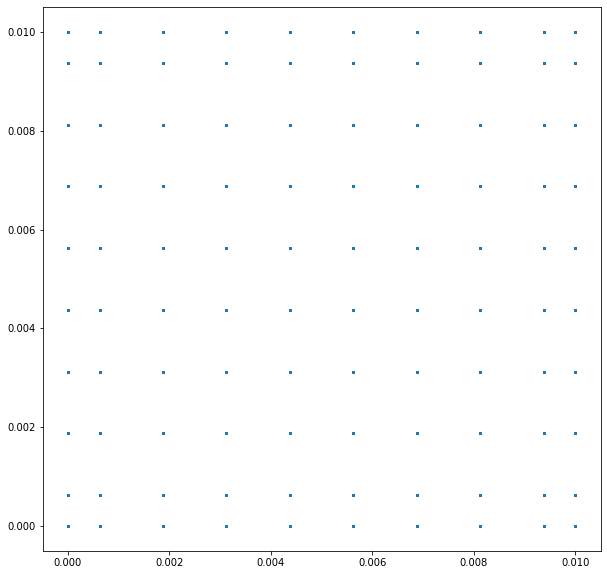

In [71]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))


# Displacement Scatter:

#
x_values = (dispx.reshape((nx+2)*(ny+2), 1) + u_new[:, 0])#*scale
y_values = (dispy.reshape((nx+2)*(ny+2), 1) + u_new[:, 1])#*scale

print(x_values.shape)

plt.scatter(x_values, y_values, s=1)

0 10
10 20
20 30
30 40
40 50
50 60
60 70
70 80
80 90
90 100


array([[-1.32835031e-21],
       [ 6.25000000e-04],
       [ 1.87500000e-03],
       [ 3.12500000e-03],
       [ 4.37500000e-03],
       [ 5.62500000e-03],
       [ 6.87500000e-03],
       [ 8.12500000e-03],
       [ 9.37500000e-03],
       [ 1.00000000e-02]])

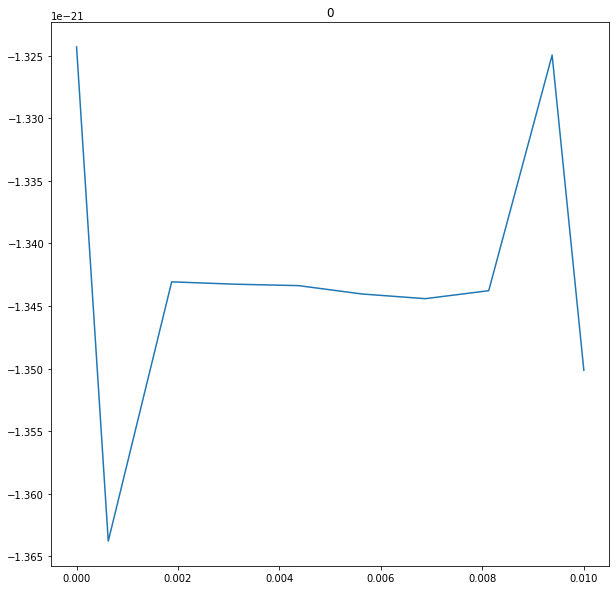

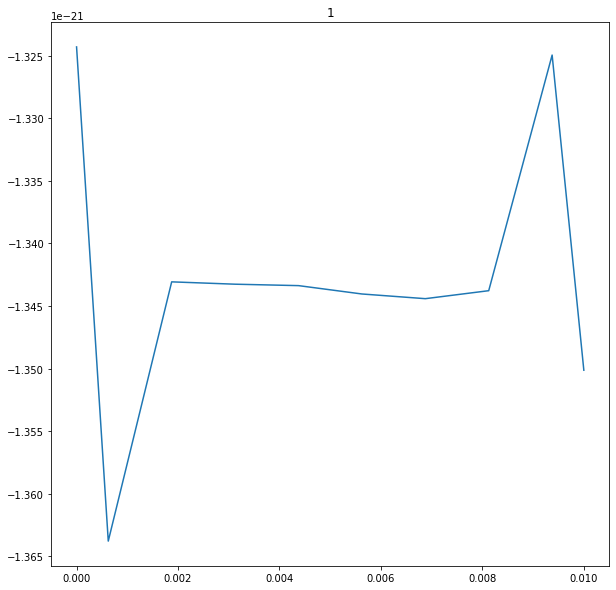

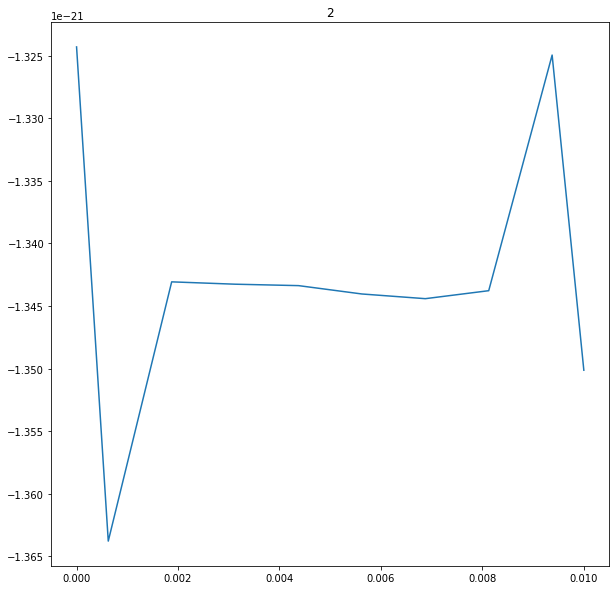

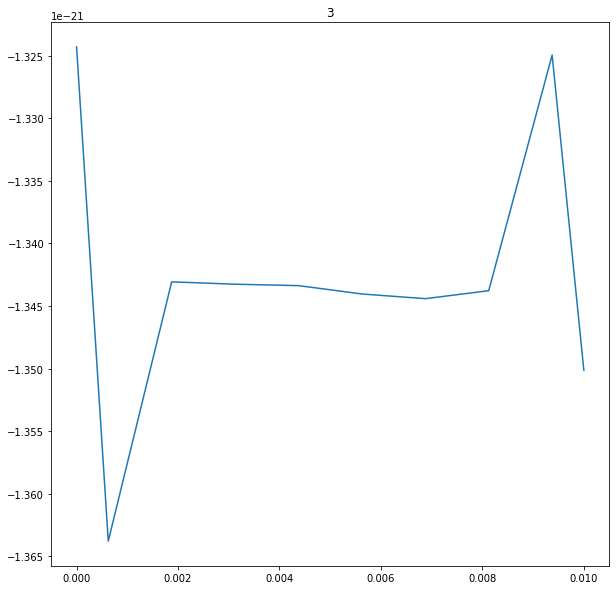

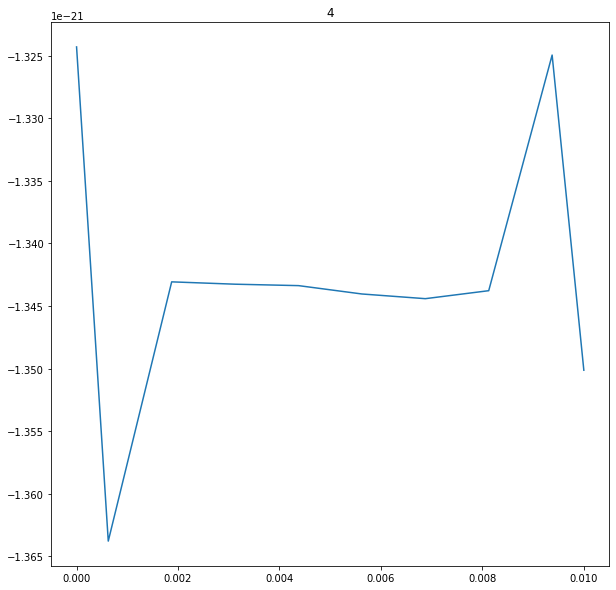

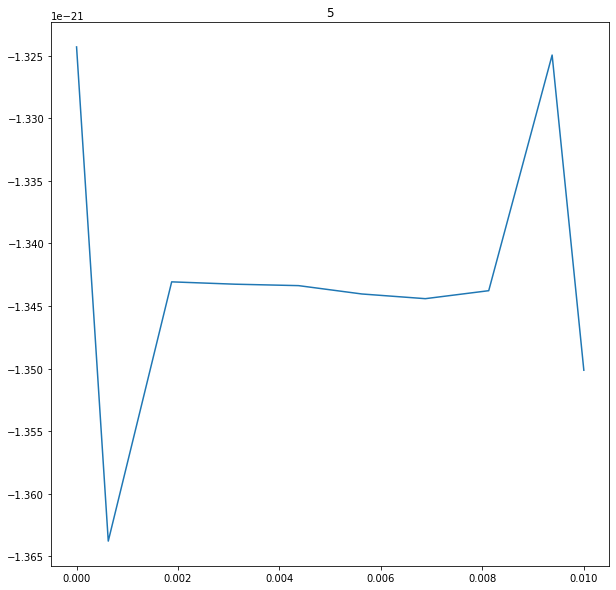

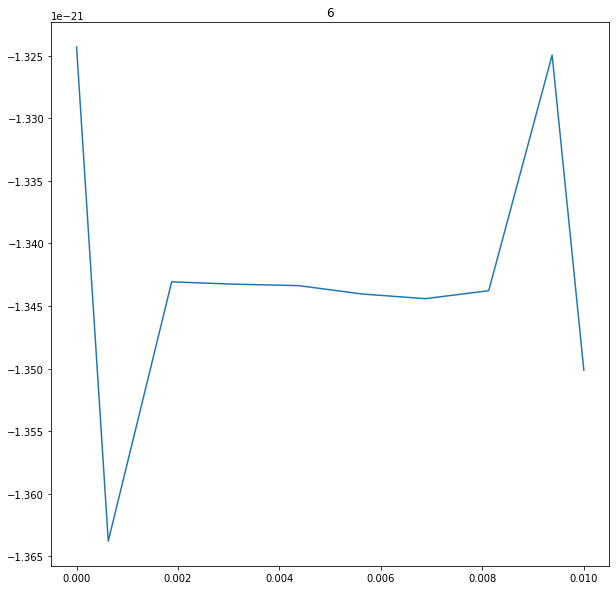

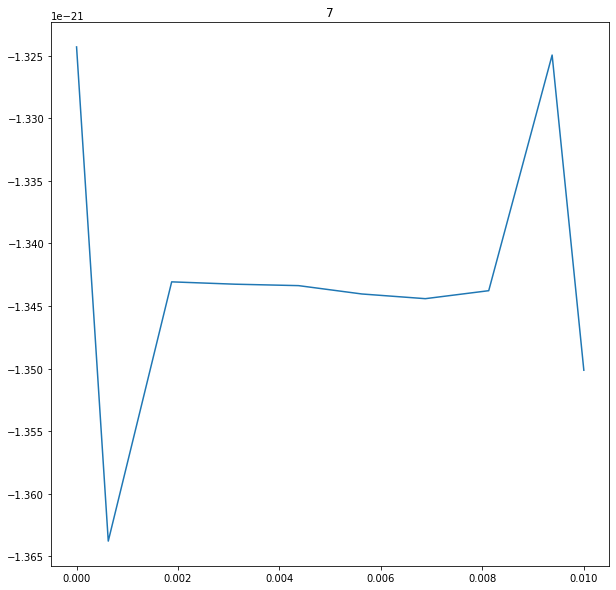

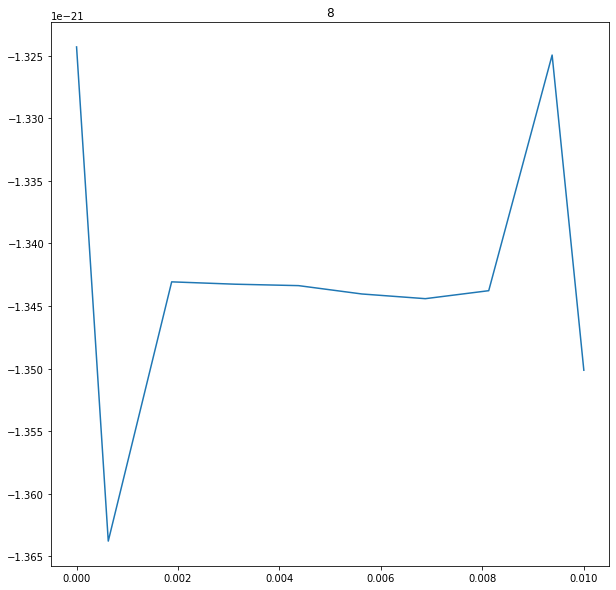

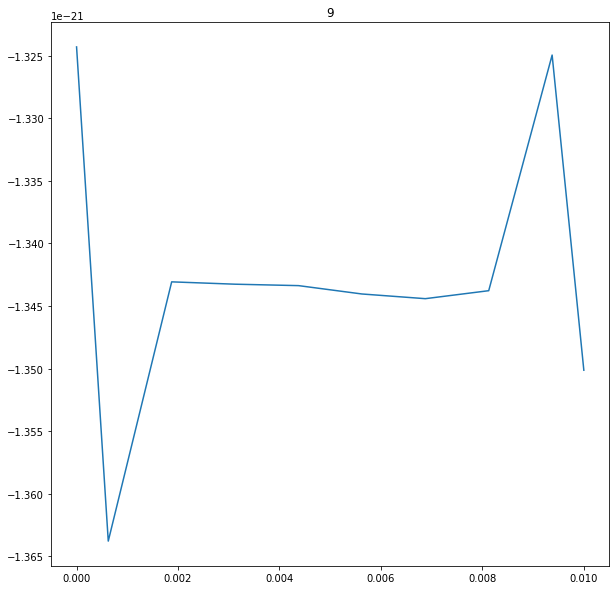

In [72]:
for i in np.arange(0,ny+2):
    
    plt.figure(figsize=(10, 10))

    print(str(0+(i*10)), str(10+(i*10)))
    
    x_values = dispx.reshape((nx+2)*(ny+2), 1)[0+(i*10):10+(i*10)] + u_new[:,0].reshape((nx+2)*(ny+2), 1)[0:10]

    y_values = u_new[:,1].reshape((nx+2)*(ny+2), 1)[0:10]

    plt.plot(x_values, y_values)
    plt.title(str(i))

    plt.show

x_values

In [73]:
u_new

array([[-1.32835031e-21, -1.32429352e-21],
       [-1.18836276e-21, -1.36378649e-21],
       [-8.36942876e-22, -1.34306937e-21],
       [-5.06090050e-22, -1.34325678e-21],
       [-1.70355307e-22, -1.34337057e-21],
       [ 1.65580946e-22, -1.34403852e-21],
       [ 5.02074020e-22, -1.34441340e-21],
       [ 8.43201313e-22, -1.34377565e-21],
       [ 1.18106310e-21, -1.32494504e-21],
       [ 1.34852546e-21, -1.35013171e-21],
       [-1.34625307e-21, -1.18229704e-21],
       [-1.17376188e-21, -1.17367724e-21],
       [-8.42022212e-22, -1.17610658e-21],
       [-5.05962449e-22, -1.17468831e-21],
       [-1.70106736e-22, -1.17532214e-21],
       [ 1.65895500e-22, -1.17606786e-21],
       [ 5.02064040e-22, -1.17697411e-21],
       [ 8.38393416e-22, -1.17647902e-21],
       [ 1.17802196e-21, -1.17443917e-21],
       [ 1.34427331e-21, -1.17204861e-21],
       [-1.34454202e-21, -8.38146178e-22],
       [-1.17734011e-21, -8.38373248e-22],
       [-8.41463174e-22, -8.38906511e-22],
       [-5.

In [74]:
Ux[0], Ux[9], Ux[90], Ux[99]

(-1.3283503083403309e-21,
 1.3485254556761223e-21,
 -1.3469184729038221e-21,
 1.361577342777039e-21)

In [75]:
Uy[0], Uy[9], Uy[90], Uy[99]

(-1.324293519047987e-21,
 -1.3501317110813703e-21,
 1.3529108004634475e-21,
 1.3563179560205793e-21)

In [76]:
Ux[0] - Uy[0]

-4.056789292343908e-24